# Concept: Cross Validation

In [243]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import HTML, display
import tabulate

### Model

We have an unknown function that we would like to fit with a polynomial of degree K. So we need to find which polynomial degree fits better and what are the coefficients of that polynomial:

$c_0 + c_1 x + c_2 x^2 + \dots + c_K x^K$

The degree of the polynomial is a hyperparameter of the model, i.e. we don't know in advance what value to assign to it, but it has direct influence on the quality of the fit.

The following function implements the model for an arbitrary polynomial:

In [244]:
def poly(x, coefficients):
    # Calculate polynomial, based on the number of coefficients in c.
    return sum([c*x**(k) for (k,c) in enumerate(coefficients[::-1])])

### Sample
We are going to use a linear function, because it can be easily overfit with a high-degree polynomial. It has also an added Gaussian noise to simulate measurement error:

In [509]:
def sample():
    return [(x,  2.24 + 0.23*x - 0.4*x**2 + 0.013*x**4 + 0.0003*x**5 + 0.25*np.random.normal() ) for x in np.linspace(-2*np.pi,0,50)]


Generate the data set:

In [510]:
data = np.array(sample())

The sample is represented graphically on the following scatter plot:

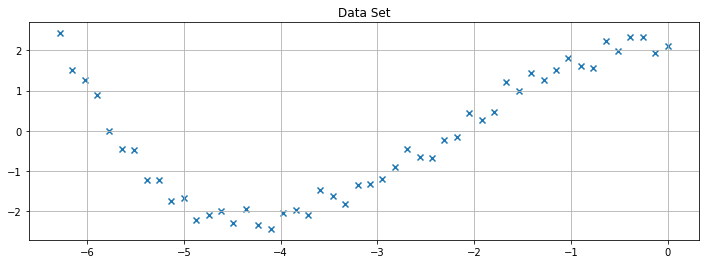

In [511]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.set_title("Data Set")
ax.grid()
# Do not print out the scatterplot object
_ = ax.scatter(data[:,0],data[:,1], marker='x')

### MSE Loss Function

The difference between the estimated function and the sample is measured by the loss function. In this case, we choose the Mean Squared Error. It calculates the quadratic difference between the estimated value of the function, $\hat{y} =  f(x)$,  at a data point $x$ and the actual value $y$. These differences are averaged over the whole data set.

$  MSE = \frac{1}{K} \sum_{i=1}^{K} \left( y_i - f(x_i) \right)^2$

Implementation:

In [512]:
def mse_loss(data, c_est):
    # data - data sample in the form [(x1,y1),...,(xn,yn)]
    # c_est - the estimated polynomial coefficients
    return sum([  (y-poly(x, c_est))**2 for (x,y) in data])/float(len(data))

### Best Fit

We perform a parameter sweep for the hyperparameter $K$ (degree of the polynomial model function), in order to find the best fit for the sample. The error tends to go down with increasing $K$:

In [513]:
%%capture
#above: There are some warnings from numpy's polyfit for large parameters K, suppress cell output
data_best_fit = data.copy()
# We want to shuffle the input data first
np.random.shuffle(data_best_fit)

# Fit the function for a range of the hyperparameter K
hyper_params_best_fit = range(1,21)
parameters_best_fit = []
errors_best_fit = []
for k in hyper_params_best_fit:
    c_est = np.polyfit(data_best_fit[:,0], data_best_fit[:,1], k)
    parameters_best_fit.append(c_est)
    errors_best_fit.append(mse_loss(data_best_fit, c_est))

In [514]:
table = list(zip(hyper_params_best_fit, errors_best_fit))
display(HTML(tabulate.tabulate(table, tablefmt='html', floatfmt='.6f',  numalign='right')))

1,1.743587
2,0.495192
3,0.037773
4,0.036195
5,0.035562
6,0.035115
7,0.034592
8,0.034410
9,0.033490
10,0.033375
11,0.033371


We can plot the hyperparameter $K$ against the loss to estimate the best fitting polynomial degree:

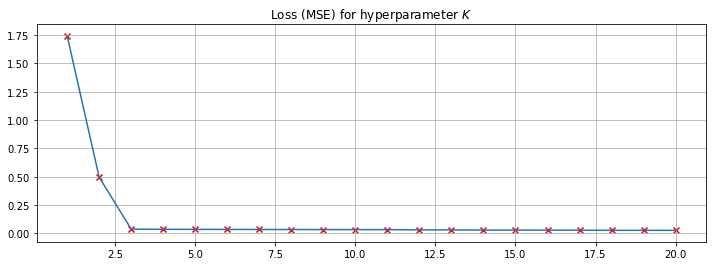

In [515]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.set_title("Loss (MSE) for hyperparameter $K$")
ax.grid()
ax.scatter(hyper_params_best_fit,errors_best_fit, marker='x', c='r')
_ = ax.plot(hyper_params_best_fit,errors_best_fit)

### Overfitting

In order to test the model, we are calculating the value of the estimated function also for other values. We can observe that these can deviate significantly from the expected values, while exactly fitting the data points. This is a classical overfitting situation and is also exacerbated by the small sample size. 

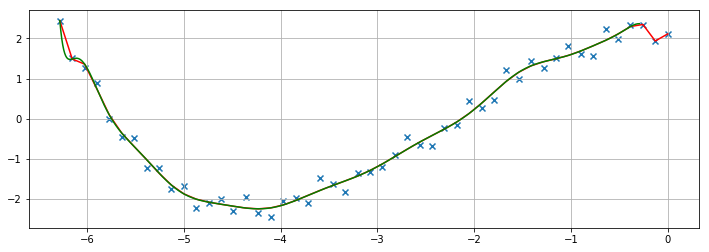

In [516]:
# Calculate the estimated function values according to the best fitted parameters (highest K)
model_estimate_best_fit = poly(data[:,0], parameters_best_fit[-1])
# Create a more fine-grained input, in order to test on new data.
x_fine_best_fit = np.arange(x.min(), x.max(), 0.01)
model_fine_best_fit = poly(x_fine_best_fit, parameters_best_fit[-1])

# Now plot the data
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.grid()
ax.scatter(data[:,0], data[:,1], marker='x')
_ = ax.plot(data[:,0], model_estimate_best_fit, c='r')
_ = ax.plot(x_fine_best_fit, model_fine_best_fit, c='g')

### Cross Validation

The problem of overfitting can be reduced if we don't show all of the training data, using a *k-fold cross validation*. Here, we choose to use 5 partitions.

In [517]:
%%capture
# Shuffle the data
data_cv = data.copy()
np.random.shuffle(data_cv)

# Partition the data into folds
fold_count = 5

# Prepare the data first
validation_sets = []
training_sets = []
for p in range(fold_count):
    validation_set = data_cv[p*part_len:(p+1)*part_len]
    training_set = np.concatenate( (data_cv[:p*part_len], data_cv[(p+1)*part_len:]), axis=0)
    validation_sets.append(validation_set)
    training_sets.append(training_set)

# Train the model for all hyperparameters
hyper_params_cv = range(2,21)
parameter_sets_cv = []
errors_cv = []
for k in hyper_params_cv:
    # We need to train using cross validation
    tmp_params = []
    tmp_errors = []
    for validation_set, training_set in zip(validation_sets, training_sets):
        c_est = np.polyfit(training_set[:,0], training_set[:,1], k)
        tmp_params.append(c_est)
        tmp_errors.append(mse_loss(validation_set, c_est))
    parameter_sets_cv.append(np.array(tmp_params).mean(axis=0))
    errors_cv.append(np.array(tmp_errors).mean())


Now we can check again how the different hyperparameters fared:

In [518]:
table_cv = list(zip(hyper_params_cv, errors_cv))
display(HTML(tabulate.tabulate(table_cv, tablefmt='html', floatfmt=".6f")))

2,0.812504
3,0.039025
4,0.041377
5,0.038843
6,0.038489
7,0.040011
8,0.056469
9,0.085021
10,0.169998
11,0.308374
12,0.157582


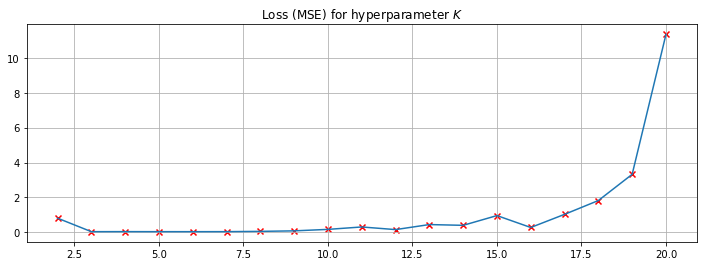

In [519]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.set_title("Loss (MSE) for hyperparameter $K$")
ax.grid()
ax.scatter(hyper_params_cv,errors_cv, marker='x', c='r')
_ = ax.plot(hyper_params_cv,errors_cv)

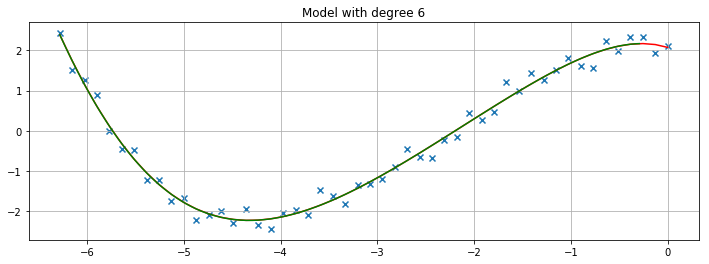

In [520]:
# Find the best parametrization
model_cv_index = np.array(errors_cv).argmin()
k = hyper_params_cv[model_cv_index]
c_est_cv = parameter_sets_cv[model_cv_index]

# Calculate the estimated function values according to the best fitted parameters (highest K)
model_estimate_cv = poly(data[:,0], c_est_cv)

# Create a more fine-grained input, in order to test on new data.
x_fine_cv = np.arange(x.min(), x.max(), 0.01)
model_fine_cv = poly(x_fine_cv, c_est_cv)

# Now plot the data
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.set_title("Model with degree {0}".format(k))
ax.grid()
ax.scatter(data[:,0], data[:,1], marker='x')
_ = ax.plot(data[:,0], model_estimate_cv, c='r')
_ = ax.plot(x_fine_cv, model_fine_cv, c='g')

